# ARIMA 

In [20]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
from itertools import product
from matplotlib import pyplot as plt, dates as mdates, ticker as mticker
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../../My-Code/')

import timetools as tt

%matplotlib inline

In [21]:
# plt.rcParams['figure.figsize'] = (10, 7.5)
plt.style.use('seaborn')

## Johnson&Johnson Quarterly Earnings per Share 

In [22]:
data = pd.read_csv('../data/jj.csv')
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84 entries, 1960-01-01 to 1980-10-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   data    84 non-null     float64
dtypes: float64(1)
memory usage: 1.3 KB


,data
date,
1960-01-01,0.71
1960-04-01,0.63
1960-07-02,0.85
1960-10-01,0.44
1961-01-01,0.61


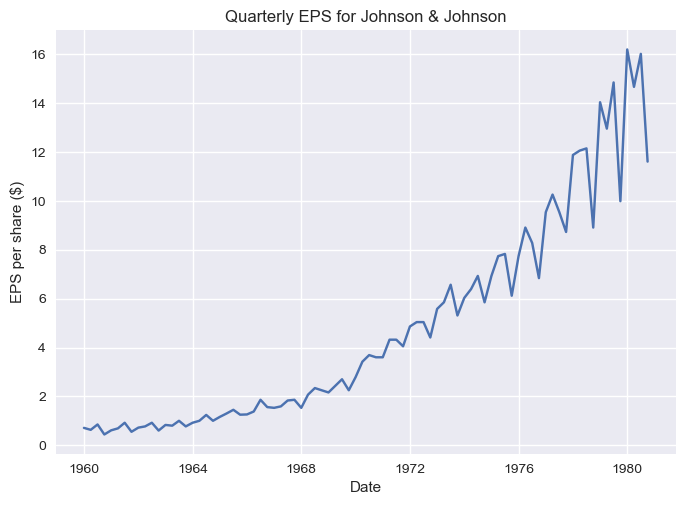

In [23]:
fig, ax = plt.subplots()
ax.plot(data)
ax.set_title('Quarterly EPS for Johnson & Johnson')
ax.set_ylabel('EPS per share ($)')
ax.set_xlabel('Date')
plt.show()

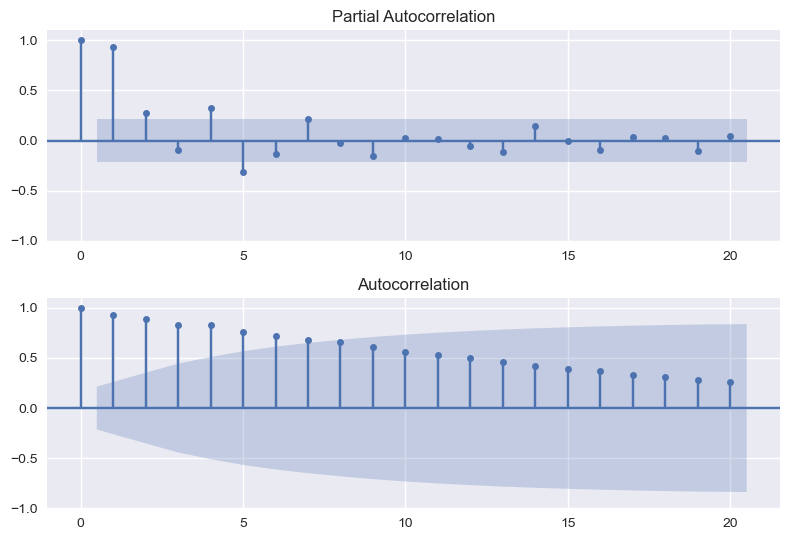

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1)
plot_pacf(data, ax=ax1)
ax1.set_ylim(top=1.1)
plot_acf(data, ax=ax2)
ax2.set_ylim(top=1.1)
plt.tight_layout();

In [25]:
tt.adf_v2(data['data'])

Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

Differenced?  d=0

Test Statistic                  2.742017
p-value                         1.000000
#Lags Used                     11.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64

The time series is not stationary.


In [26]:
tt.adf_v2(data['data'], diff=1)

Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

Differenced?  d=1

Test Statistic                 -0.407410
p-value                         0.908854
#Lags Used                     10.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64

The time series is not stationary.


#### log and difference of order 1

In [27]:
tt.adf_v2(np.log(data['data']), diff=1)

Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

Differenced?  d=1

Test Statistic                 -4.317044
p-value                         0.000415
#Lags Used                      5.000000
Number of Observations Used    77.000000
Critical Value (1%)            -3.518281
Critical Value (5%)            -2.899878
Critical Value (10%)           -2.587223
dtype: float64

The time series is stationary.


In [28]:
data['data_tr_1'] = np.log(data['data'])
data['data_tr_1'] = data['data_tr_1'].diff()

data.head(10)

,data,data_tr_1
date,,
1960-01-01,0.71,NaN
1960-04-01,0.63,-0.119545
1960-07-02,0.85,0.299517
1960-10-01,0.44,-0.658462
1961-01-01,0.61,0.326684
1961-04-02,0.69,0.123233
1961-07-02,0.92,0.287682
1961-10-01,0.55,-0.514455
1962-01-01,0.72,0.269333


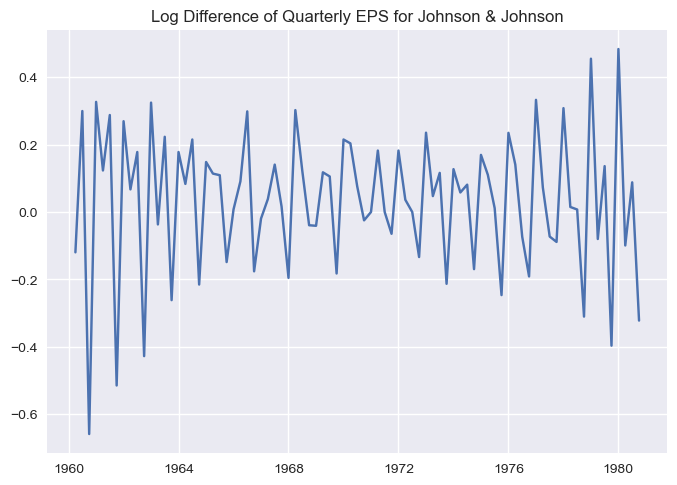

In [29]:
plt.plot(data['data_tr_1'])
plt.title("Log Difference of Quarterly EPS for Johnson & Johnson")
plt.show()

In [30]:
ad_fuller_result = adfuller(data['data_tr_1'][1:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -4.317043945811829
p-value: 0.00041497314044407825


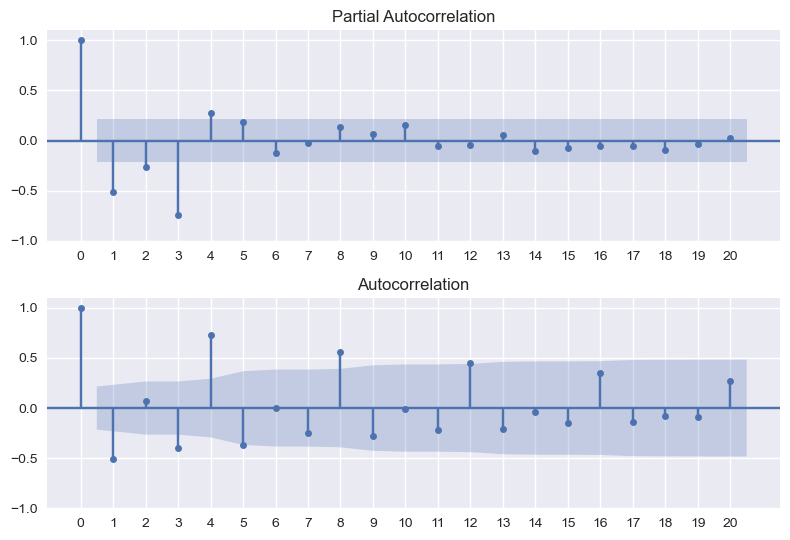

In [31]:
fig, (ax1, ax2) = plt.subplots(2, 1)
plot_pacf(data['data_tr_1'][1:], ax=ax1)
ax1.set_ylim(-1, 1.1)
ax1.xaxis.set_major_locator(mticker.FixedLocator(np.arange(0, 21)))
ax1.xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,}'))
plot_acf(data['data_tr_1'][1:],ax=ax2)
ax2.set_ylim(-1, 1.1)
ax2.xaxis.set_major_locator(mticker.FixedLocator(np.arange(0, 21)))
plt.tight_layout();

In [32]:
def optimize_ARIMA(endog, order_list):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        endog - the observed variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=order, simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [33]:
ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)
    
order_list[:10]

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (1, 1, 0),
 (1, 1, 1)]

In [35]:
ps = range(0, 5, 1) 
qs = range(0, 5, 1)
Ps = range(0, 5, 1)
Qs = range(0, 5, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs)) 

train = np.log(data['data'])[:-4] 
d=1 
D=0 
s = 4
SARIMA_result_df = tt.optimize_SARIMA(train, SARIMA_order_list, d, D, s) 

  0%|          | 0/625 [00:00<?, ?it/s]

In [38]:
SARIMA_result_df.head()

,"(p,q,P,Q)",AIC
0,"(0, 1, 2, 0)",-139.742066
1,"(0, 1, 1, 1)",-139.450674
2,"(2, 3, 2, 0)",-139.358643
3,"(0, 1, 3, 1)",-139.234958
4,"(0, 1, 1, 2)",-138.032440


In [41]:
SARIMA_model = SARIMAX(train, order=(0, d, 1), seasonal_order=(2,D,0,s), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               data   No. Observations:                   80
Model:             SARIMAX(0, 1, 1)x(2, 0, [], 4)   Log Likelihood                  73.871
Date:                            Mon, 09 Jan 2023   AIC                           -139.742
Time:                                    20:34:32   BIC                           -130.264
Sample:                                         0   HQIC                          -135.945
                                             - 80                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6814      0.091     -7.516      0.000      -0.859      -0.504
ar.S.L4        0.6484      0.111   

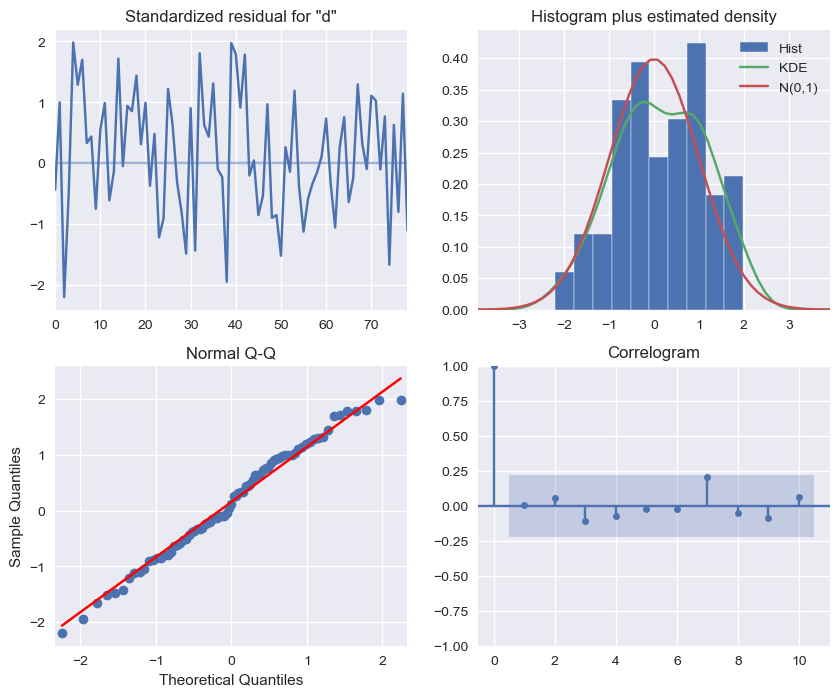

In [42]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

Minimum p-value: 0.67 > 0.05
The residuals are independent and not correlated.  Like white noise!


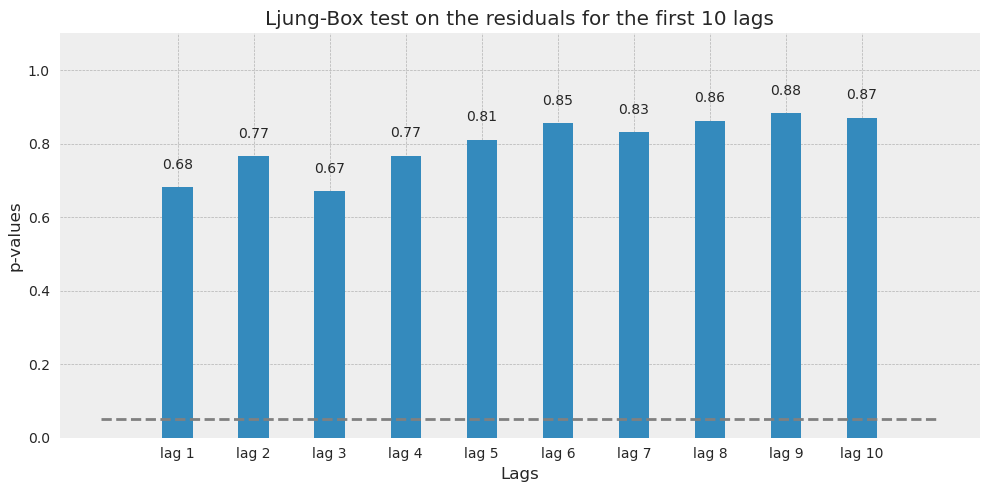

In [43]:
tt.ljungbox(SARIMA_model_fit.resid)

In [46]:
import datetime

dti = pd.date_range("1979-12-01", periods=8, freq="Q")
dti

DatetimeIndex(['1979-12-31', '1980-03-31', '1980-06-30', '1980-09-30',
               '1980-12-31', '1981-03-31', '1981-06-30', '1981-09-30'],
              dtype='datetime64[ns]', freq='Q-DEC')

In [76]:
pred = SARIMA_model_fit.forecast(8)
pred_transformed = np.exp(pred)
preds = pd.DataFrame(pred_transformed.values, index=dti, columns=['prediction'])
preds

,prediction
1979-12-31,15.686443
1980-03-31,14.957611
1980-06-30,16.372866
1980-09-30,11.581737
1980-12-31,17.685036
1981-03-31,16.757739
1981-06-30,18.478595
1981-09-30,13.173163


In [72]:
test['prediction'] = pred_transformed.values[:4]
test

,data,prediction
date,,
1980-01-01,16.20,15.686443
1980-04-01,14.67,14.957611
1980-07-02,16.02,16.372866
1980-10-01,11.61,11.581737


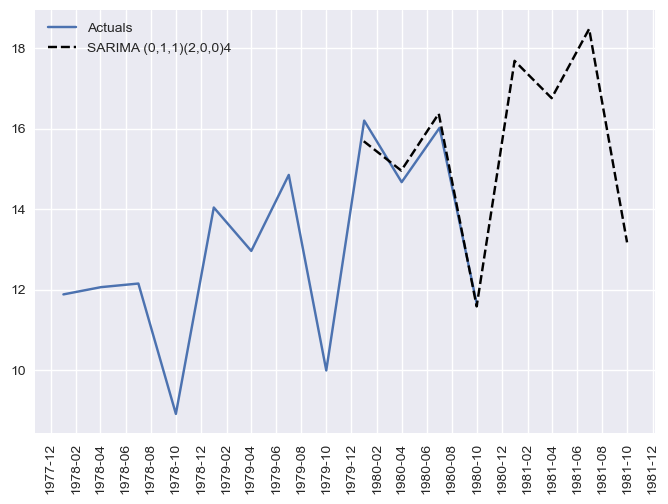

In [85]:
plt.style.use('seaborn')
fig, ax = plt.subplots()
ax.plot(data.loc['1978':]['data'], label='Actuals')
ax.plot(preds, ls='--', color='black', label='SARIMA (0,1,1)(2,0,0)4')
ax.xaxis.set_major_locator(mdates.MonthLocator([0, 2, 4, 6, 8, 10, 12]))
plt.xticks(rotation = 90)
plt.legend();

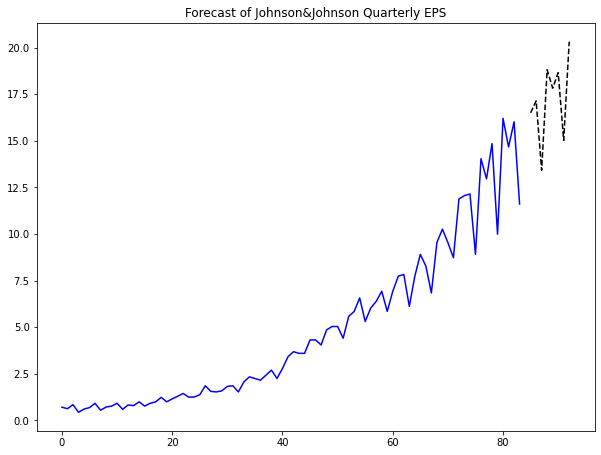

In [41]:
n_forecast = 8
predict = res.get_prediction(end=best_model.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))

fig, ax = plt.subplots()
ax.plot(data['data'], 'blue')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')

ax.set(title='Forecast of Johnson&Johnson Quarterly EPS')
plt.show()

In [35]:
data['model'] = predict.predicted_mean
data.head(15)

,date,data,data_tr_1,model
0,1960-01-01,0.71,NaN,0.000000
1,1960-04-01,0.63,-0.119545,0.709998
2,1960-07-02,0.85,0.299517,0.678566
3,1960-10-01,0.44,-0.658462,0.722026
4,1961-01-01,0.61,0.326684,0.649570
5,1961-04-02,0.69,0.123233,0.528291
6,1961-07-02,0.92,0.287682,0.787676
7,1961-10-01,0.55,-0.514455,0.493006
8,1962-01-01,0.72,0.269333,0.646793
9,1962-04-02,0.77,0.067139,0.752807


In [38]:
mse = mean_squared_error(data['data'], data['model'])
print(f'MSE: {mse}')

MSE: 0.16237821078357895
